This notebook reproduces Figure 2 in "Integrating human biophysics and data-driven analysis to assess humidity’s role in heatstroke prediction" by Kong et al.

In [1]:
"""
import python packages
please install required packages before running this notebook
"""
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import geopandas as gpd
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# read in mean absolute prediction error of GHSI
mae=xr.open_dataset('../data/GHSI_MAE.nc').MAE
"""
MAE of daily heatstroke prediction at each prefecture (dim: pf);
Conditional on a wide range of humidity weight (dim: beta);
For both outdoor and indoor versions (dim: exposure) of General Heat Stress Index (GHSI);
MAE is calculated as an average across the validation periods of 10-fold cross validation
"""
mae

<xarray.DataArray 'MAE' (pf: 47, exposure: 2, beta: 2451)>
[230394 values with dtype=float64]
Coordinates:
  * beta      (beta) float64 -8.0 -7.99 -7.98 -7.97 ... 16.47 16.48 16.49 16.5
  * exposure  (exposure) object 'outdoor' 'indoor'
  * pf        (pf) int64 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46 47
Attributes:
    long_name:  Mean absolute error (MAE) of daily heatstroke prediction at e...

In [3]:
mae=mae*122/1000 # scale daily MAE to summer total in 10^3
Tokyo=mae.sel(pf=13) # select Tokyo with prefecture index=13
Osaka=mae.sel(pf=27) # select Osaka with prefecture index=27

In [4]:
# determine optimal humidity weight (beta) with lowest MAE for each prefecture
optimal_beta_prefecture=mae.idxmin(dim='beta')
# determine optimal humidity weight (beta) with lowest MAE at country level
optimal_beta_country=mae.mean('pf').idxmin('beta')

In [5]:
# calculate lowest MAE of heatstroke prediction at each prefecture across a wide range of beta
lowest_mae_prefecture=mae.min('beta')
# calculate lowest MAE of heatstroke prediction at country level across a wide range of beta
lowest_mae_country=mae.mean('pf').min('beta')

In [6]:
# Load Japan prefecture shapefile
url = "https://raw.githubusercontent.com/dataofjapan/land/master/japan.geojson"
gdf = gpd.read_file(url)

# add a column to gdf representing optimal beta of each prefecture based on outdoor version of GHSI
tmp=[]
for k in range(47):
    index=gdf.id[k]
    tmp.append(optimal_beta_prefecture.sel(exposure='outdoor').sel(pf=index).values.item())
gdf['outdoor']=tmp

# add a column to gdf representing optimal beta of each prefecture based on indoor version of GHSI
tmp=[]
for k in range(47):
    index=gdf.id[k]
    tmp.append(optimal_beta_prefecture.sel(exposure='indoor').sel(pf=index).values.item())
gdf['indoor']=tmp


Text(0.5, 1, '$\\mathrm{GHSI}_{\\mathrm{in}}$')

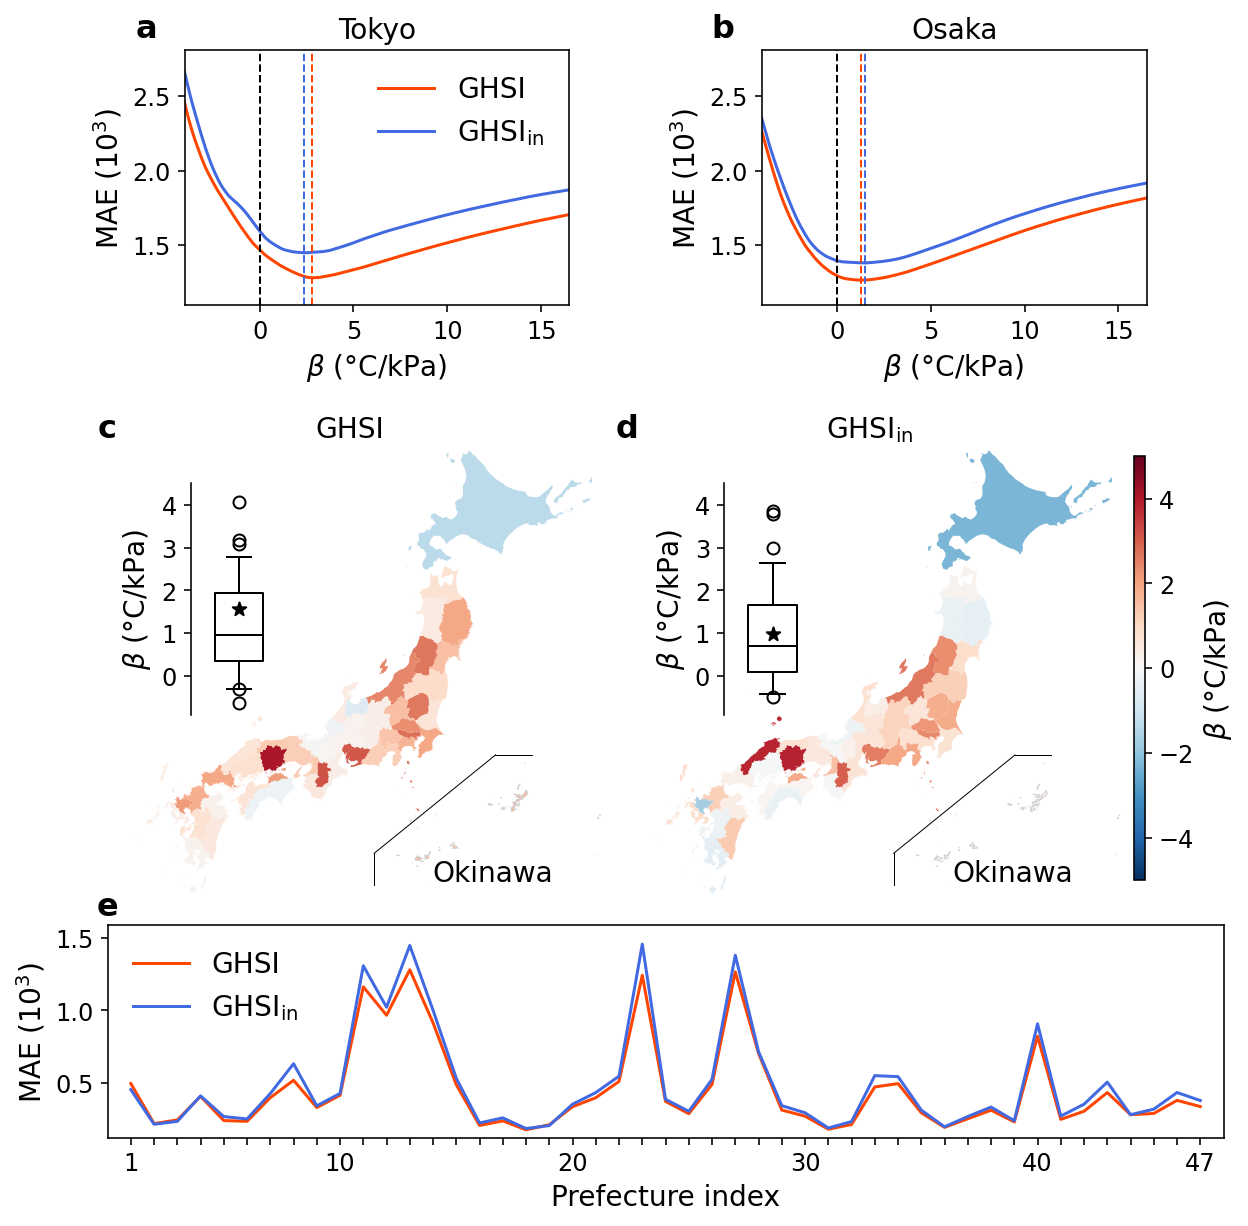

In [7]:
tick_size=12
label_size=14
annote_size=16

red='orangered'
blue = 'royalblue'

# subplot for panel a and b
def subplot1(ax,x,y1,y2,title):
    p=ax.plot(x,y1,linewidth=1.5,color=red,label='GHSI')
    p=ax.plot(x,y2,linewidth=1.5,color=blue,label=r'$\mathrm{GHSI}_{\mathrm{in}}$')
    ax.set_xlabel(r'$\beta$ (°C/kPa)',fontsize=label_size)
    ax.set_ylabel('MAE '+ '('+r'$\mathrm{10}^{\mathrm{3}}$'+')',fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    ax.set_title(title,fontsize=label_size)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=x[y1.argmin().values.item()],color=red,linestyle='--', linewidth=1)
    ax.axvline(x=x[y2.argmin().values.item()],color=blue,linestyle='--', linewidth=1)
    ax.set_xlim(-4,16.5)
    return p

# subplot for panel e
def subplot2(ax,x,y1,y2):
    p=ax.plot(x,y1,linewidth=1.5,color=red,label='GHSI')
    p=ax.plot(x,y2,linewidth=1.5,color=blue,label=r'$\mathrm{GHSI}_{\mathrm{in}}$')
    ax.set_xlabel('Prefecture index',fontsize=label_size)
    ax.set_ylabel('MAE '+ '('+r'$\mathrm{10}^{\mathrm{3}}$'+')',fontsize=label_size)
    ax.tick_params(axis='both', labelsize=tick_size)
    return p

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(5, 7, height_ratios=[1.2,0.2, 4,-0.3, 1],width_ratios=[0.2,1,0.2,0.1,0.2,1,0.2],hspace=-0.2,wspace=0)

ax1 = fig.add_subplot(gs[0, 1])  
ax2 = fig.add_subplot(gs[0, 5])  
ax3 = fig.add_subplot(gs[2, 0:3]) 
ax4 = fig.add_subplot(gs[2, 4:]) 
ax5 = fig.add_subplot(gs[4, :])  

# panel a: MAE for heatstroke prediction in Tokyo prefecture
subplot1(ax1,Tokyo.beta.values,
         Tokyo.sel(exposure='outdoor'),
         Tokyo.sel(exposure='indoor'),'Tokyo')

# panel b: MAE for heatstroke prediction in Osaka prefecture
subplot1(ax2,Osaka.beta.values,
         Osaka.sel(exposure='outdoor'),
         Osaka.sel(exposure='indoor'),'Osaka')

ax1.legend(fontsize=14,frameon=False)
ax1.set_ylim(9*122/1000,23*122/1000)
ax1.set_yticks([1.5,2,2.5])

ax2.set_ylim(9*122/1000,23*122/1000)
ax2.set_yticks([1.5,2,2.5])


# panel c and d: map of optimal beta at each prefecture
cmap = 'RdBu_r'
norm = colors.Normalize(vmin=-5, vmax=5)
mainland_extent = [127, 147, 30, 46] # Japan mainland lat/lon extent
okinawa_extent = [122, 132, 23, 28] # Okinawa lat/lon extent

for ax, col, title in zip([ax3,ax4], ['outdoor', 'indoor'], [ 'GHSI', r'$\mathrm{GHSI}_{\mathrm{in}}$']):
    # Japan mainland
    gdf.plot(column=col, ax=ax, cmap=cmap, norm=norm,
                  edgecolor='lightgrey', linewidth=0,
                  legend=False, missing_kwds={"color": "lightgrey", "label": "No data"})
    ax.set_xlim(mainland_extent[0], mainland_extent[1])
    ax.set_ylim(mainland_extent[2], mainland_extent[3])
    ax.axis('off')

    # Okinawa
    ax_inset = inset_axes(ax, width="50%", height="31.25%", loc='lower left', bbox_to_anchor=(0.55, 0, 1, 1), bbox_transform=ax.transAxes,borderpad=0)
    gdf[gdf["nam"] == "Okinawa Ken"].plot(column=col, ax=ax_inset, cmap=cmap, norm=norm,
                  edgecolor='lightgrey', linewidth=0.4,
                  legend=False, missing_kwds={"color": "lightgrey", "label": "No data"})
    ax_inset.set_xlim(okinawa_extent[0], okinawa_extent[1])
    ax_inset.set_ylim(okinawa_extent[2], okinawa_extent[3])
    ax_inset.axis('off')

    ax.plot([143, 144.5], [35, 35], c='k', linewidth=0.5)
    ax.plot([138, 138], [30.5, 31.6], c='k', linewidth=0.5)
    ax.plot([138, 143], [31.6, 35], c='k', linewidth=0.5)
    ax_inset.text(124.4, 23.5, 'Okinawa', fontsize=label_size)
# colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=[ax3,ax4], orientation='vertical', pad=0.02,
                    fraction=0.08, aspect=40, shrink=0.5)
cbar.set_label(r'$\beta$ (°C/kPa)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)


# insert box plot to represent statistical distribution of optimal beta across prefectures
# panel c for outdoor GHSI
ax_inset3 = inset_axes(ax3, width="50%", height="50%", loc='lower left', bbox_to_anchor=(-0.9, 0.4, 1, 1), bbox_transform=ax.transAxes,borderpad=0)
ax_inset3.boxplot(optimal_beta_prefecture.sel(exposure='outdoor'),whis=(5,95),widths=0.1, positions=[0],medianprops=dict(color="black"))
ax_inset3.spines['top'].set_visible(False)
ax_inset3.spines['right'].set_visible(False)
ax_inset3.spines['bottom'].set_visible(False)
ax_inset3.set_xticks([])
ax_inset3.set_xticklabels([])
ax_inset3.set_xlim(-0.1, 0.4)
ax_inset3.set_ylim(-0.9,4.5)
ax_inset3.set_yticks([0,1,2,3,4])
ax_inset3.tick_params(axis='both', labelsize=tick_size)
ax_inset3.set_facecolor("none") 
ax_inset3.patch.set_alpha(0) 
ax_inset3.scatter(0,optimal_beta_country.sel(exposure='outdoor'),marker='*',c='k',s=50)
ax_inset3.set_ylabel(r'$\beta$ (°C/kPa)', fontsize=label_size)

# insert box plot to represent statistical distribution of optimal beta across prefectures
# panel d for indoor GHSI
ax_inset4 = inset_axes(ax4, width="50%", height="50%", loc='lower left', bbox_to_anchor=(0.2, 0.4, 1, 1), bbox_transform=ax.transAxes,borderpad=0)
ax_inset4.boxplot(optimal_beta_prefecture.sel(exposure='indoor'),whis=(5,95),widths=0.1, positions=[0],medianprops=dict(color="black"))
ax_inset4.spines['top'].set_visible(False)
ax_inset4.spines['right'].set_visible(False)
ax_inset4.spines['bottom'].set_visible(False)
ax_inset4.set_xticks([])
ax_inset4.set_xticklabels([])
ax_inset4.set_xlim(-0.1, 0.4)
ax_inset4.set_ylim(-0.9,4.5)
ax_inset4.set_yticks([0,1,2,3,4])
ax_inset4.tick_params(axis='both', labelsize=tick_size)
ax_inset4.set_facecolor("none")  
ax_inset4.patch.set_alpha(0)
ax_inset4.scatter(0,optimal_beta_country.sel(exposure='indoor'),marker='*',c='k',s=50)
ax_inset4.set_ylabel(r'$\beta$ (°C/kPa)', fontsize=label_size)

# panel e: lowest mae at each prefecture corresponding to the optimal beta for both outdoor and indoor GHSI
subplot2(ax5,np.arange(1,48),
         lowest_mae_prefecture.sel(exposure='outdoor'),
        lowest_mae_prefecture.sel(exposure='indoor'))

ax5.set_xticks(np.arange(1,48))
ax5.set_xticklabels([str(i) if i in [1, 10, 20, 30, 40,47] else '' for i in range(1, 48)])
ax5.set_xlim(0,48)
ax5.set_ylim(1*122/1000,13*122/1000)
ax5.set_yticks([0.5,1,1.5])
ax5.legend(fontsize=14,frameon=False)

# add annotation
anno_opts = dict(xy=(-0.1, 1.05), xycoords='axes fraction',va='baseline', ha='center')
ax1.annotate('a', **anno_opts,fontsize=annote_size,fontweight='bold')  
ax2.annotate('b', **anno_opts,fontsize=annote_size,fontweight='bold')
anno_opts = dict(xy=(0, 1), xycoords='axes fraction',va='baseline', ha='center')
ax3.annotate('c', **anno_opts,fontsize=annote_size,fontweight='bold')  
ax4.annotate('d', **anno_opts,fontsize=annote_size,fontweight='bold') 
anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='baseline', ha='center')
ax5.annotate('e', **anno_opts,fontsize=annote_size,fontweight='bold')  
anno_opts = dict(xy=(0.5, 1), xycoords='axes fraction',va='baseline', ha='center')
ax3.annotate('GHSI', **anno_opts,fontsize=label_size)  
ax4.annotate(r'$\mathrm{GHSI}_{\mathrm{in}}$', **anno_opts,fontsize=label_size) 

**Figure 2**: (a,b) Summer cumulative mean absolute error (MAE) of prediction on daily heatstroke-related emergency ambulance dispatches in Tokyo and Osaka based on the General Heat Stress Index (GHSI) and its indoor formulation ($\mathrm{GHSI_{in}}$) across a range of β values. Dashed vertical lines indicate the optimal β values that minimize MAE. (c,d) Spatial distribution of optimal β for GHSI and $\mathrm{GHSI_{in}}$ in Japan. Insets summarize the distribution of optimal β across 47 prefectures (boxes: interquartile range; whiskers: 5th–95th percentiles; horizontal line: median). The black star denotes the national-level optimal β that minimizes total MAE across all prefectures. (e) Summer cumulative MAE for GHSI and $\mathrm{GHSI_{in}}$ in each prefecture, conditioned on their prefecture-specific optimal β.